In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

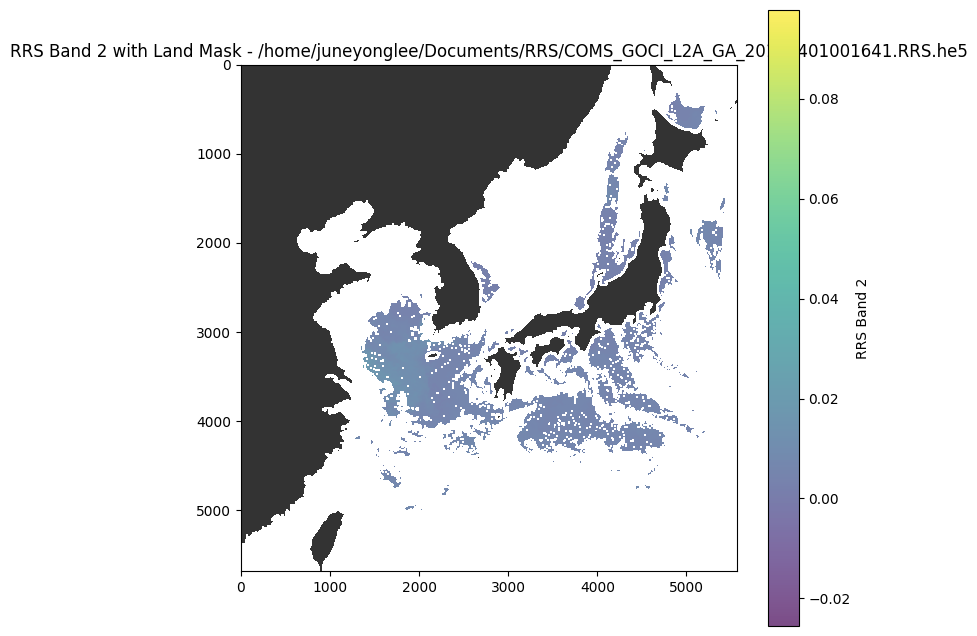

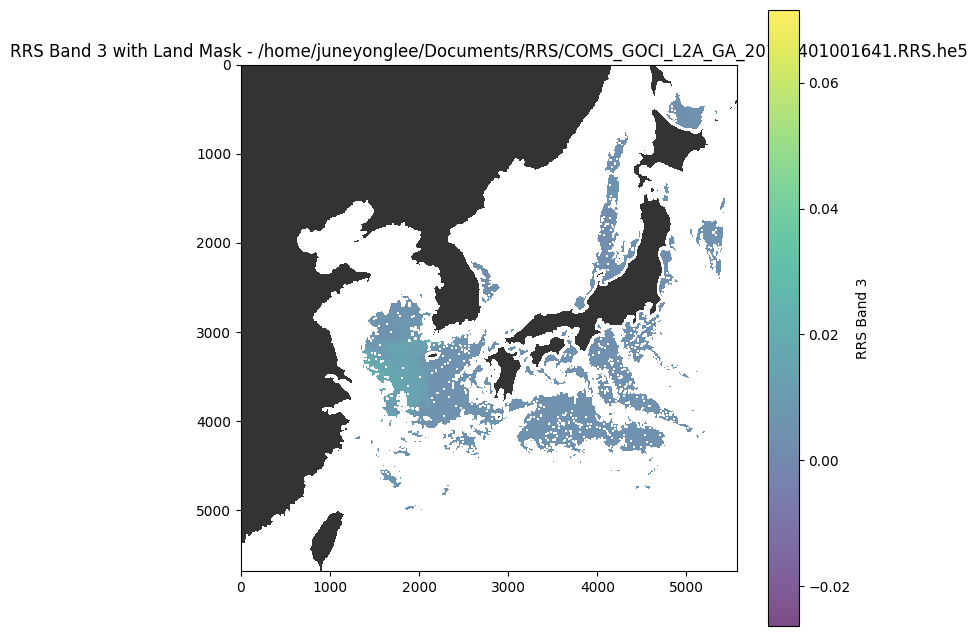

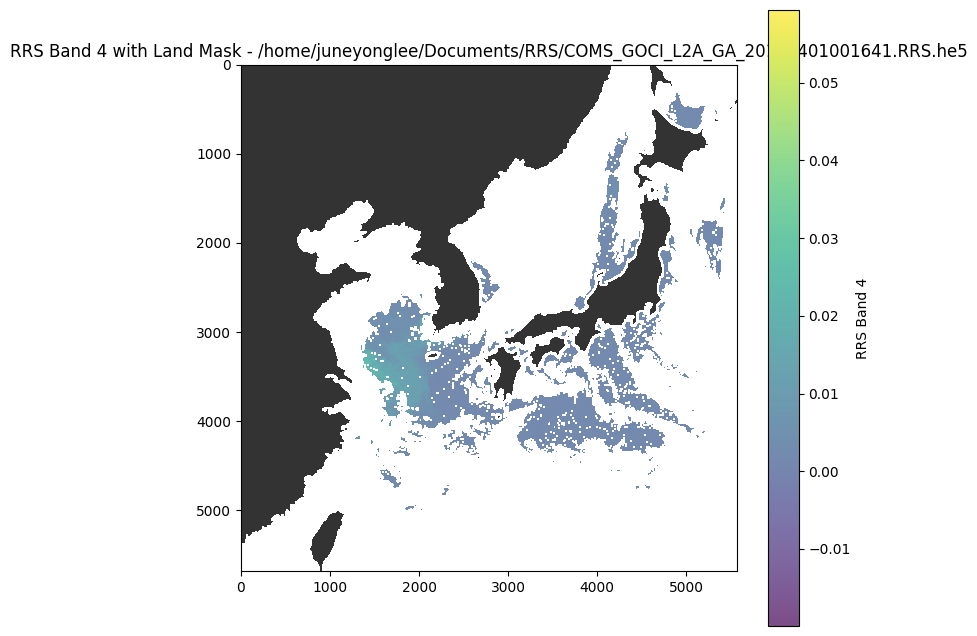

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# RRS 파일 경로 및 육지/바다 npy 파일 경로
file_path = '/home/juneyonglee/Documents/RRS/COMS_GOCI_L2A_GA_20110401001641.RRS.he5'
land_mask_path = '/home/juneyonglee/Desktop/AY_ust/preprocessing/is_land_on_GOCI.npy'

# 사용할 밴드 리스트 (2, 3, 4번 밴드 예시)
band_lst = [2, 3, 4]

# 특정 범위의 좌표 설정 (필요에 따라 지정할 수 있습니다. 여기서는 전체 범위를 사용)
# 범위를 설정하지 않으면 데이터 전체를 사용합니다.
y_min, y_max = 0, None
x_min, x_max = 0, None

def display_rrs_with_land_mask(file_path, land_mask_path, band_lst, y_min=None, y_max=None, x_min=None, x_max=None):
    # 육지/바다 마스크 불러오기
    land_mask = np.load(land_mask_path)

    # netCDF 파일 열기
    try:
        f = nc.Dataset(file_path, 'r')
    except:
        print(f"Failed to open file: {file_path}")
        return

    # 각 밴드에 대해 데이터 읽고 시각화
    for band in band_lst:
        try:
            # netCDF 형식으로 데이터를 읽음
            rrs_data = f['HDFEOS']['GRIDS']['Image Data']['Data Fields']['Band ' + str(band) + ' RRS Image Pixel Values']
        except KeyError:
            print(f"Band {band} not found in file {file_path}")
            continue

        # numpy 배열로 변환
        np_rrs = np.array(rrs_data)

        # 지정된 좌표 범위 내 데이터만 선택
        np_rrs = np_rrs[y_min:y_max, x_min:x_max]

        # 육지 마스크도 동일한 범위로 자르기
        land_mask_cropped = land_mask[y_min:y_max, x_min:x_max]

        # 결측치를 처리 (보통 -999.0 값을 결측치로 가정)
        np_rrs = np.where(np_rrs == -999.0, np.nan, np_rrs)

        # 이미지 출력
        plt.figure(figsize=(8, 8))
        
        # RRS 데이터 이미지
        plt.imshow(np_rrs, cmap='viridis', alpha=0.7)
        plt.colorbar(label=f'RRS Band {band}')
        
        # 육지 마스크를 빨간색으로 강조 (land_mask가 1이면 육지, 0이면 바다라고 가정)
        plt.imshow(np.ma.masked_where(land_mask_cropped == 0, land_mask_cropped), cmap=ListedColormap(['black', 'white']), alpha=0.8)

        plt.title(f'RRS Band {band} with Land Mask - {file_path}')
        plt.show()

    # 파일 닫기
    f.close()

# 밴드별로 RRS 데이터와 육지 마스크 함께 시각화
display_rrs_with_land_mask(file_path, land_mask_path, band_lst, y_min, y_max, x_min, x_max)


Band 2 unique values: [-9.9900000e+02 -2.5540330e-02 -2.3389757e-02 ...  5.0626244e-02
  9.7815126e-02            nan]
Band 2 data type: float32
Band 2 has data type: float32


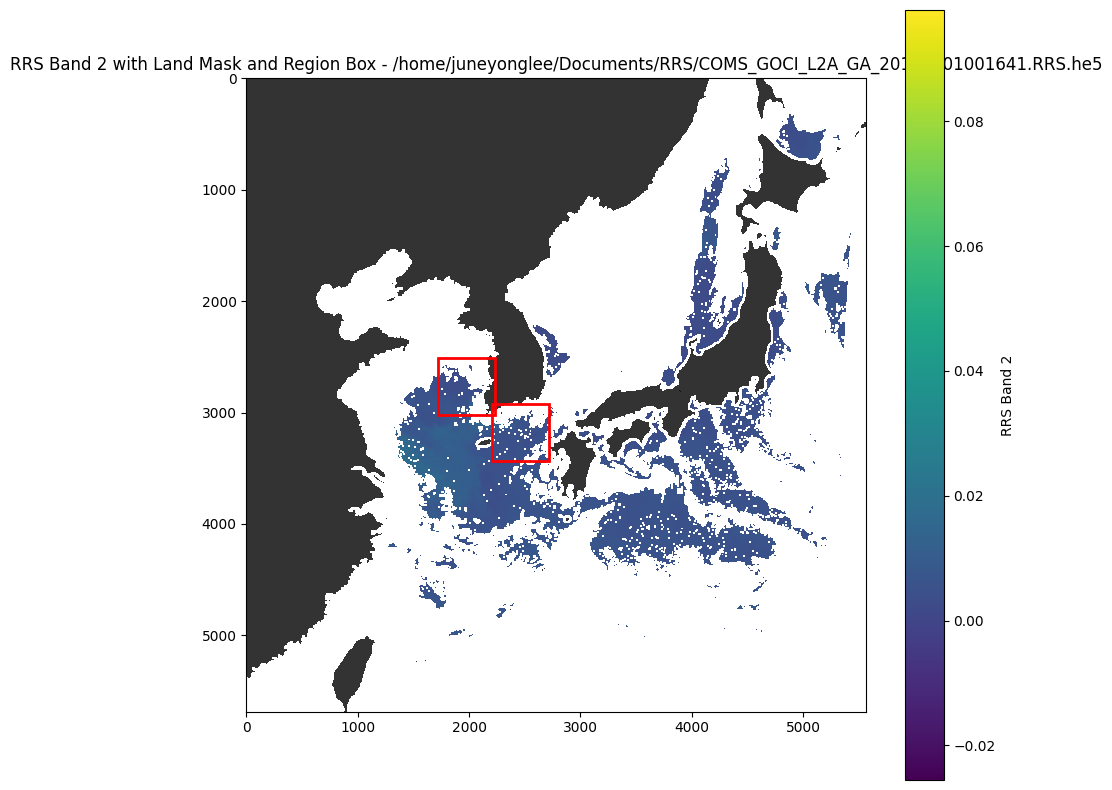

Band 3 unique values: [-9.9900000e+02 -2.6318939e-02 -2.5868699e-02 ...  4.9201962e-02
  7.1533538e-02            nan]
Band 3 data type: float32
Band 3 has data type: float32


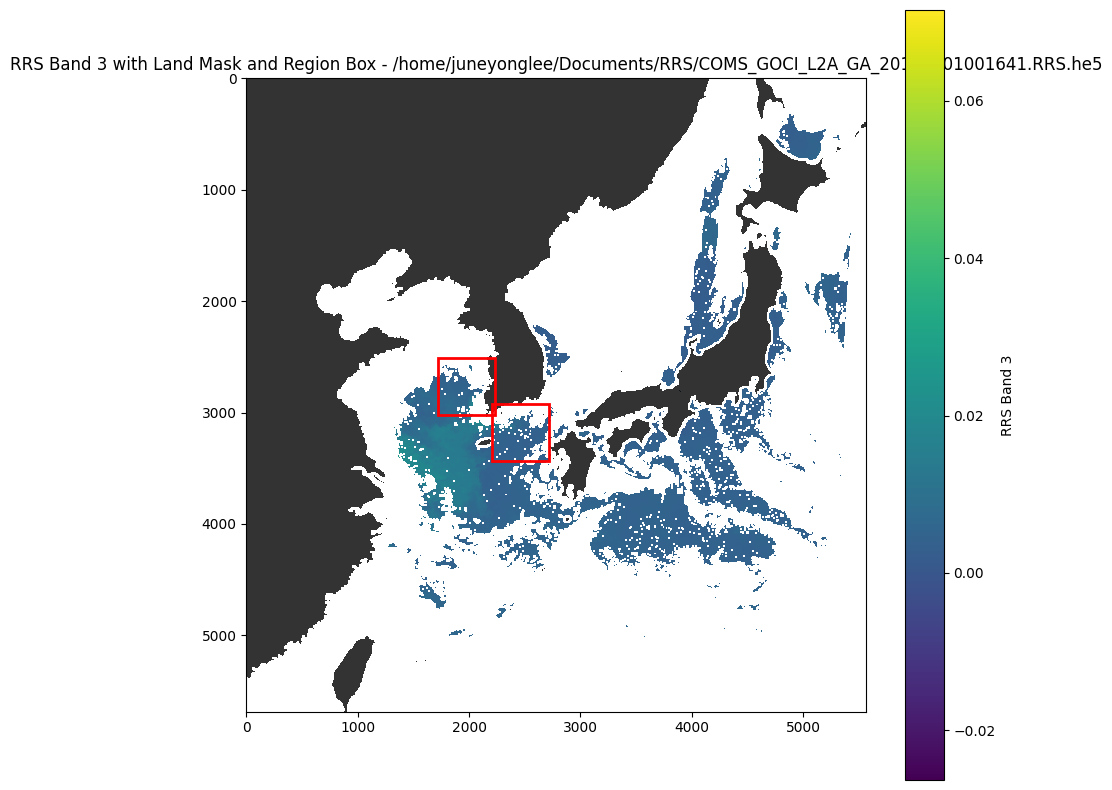

Band 4 unique values: [-9.9900000e+02 -1.9909916e-02 -1.9639613e-02 ...  3.6565781e-02
  3.7591778e-02  5.9344467e-02]
Band 4 data type: float32
Band 4 has data type: float32


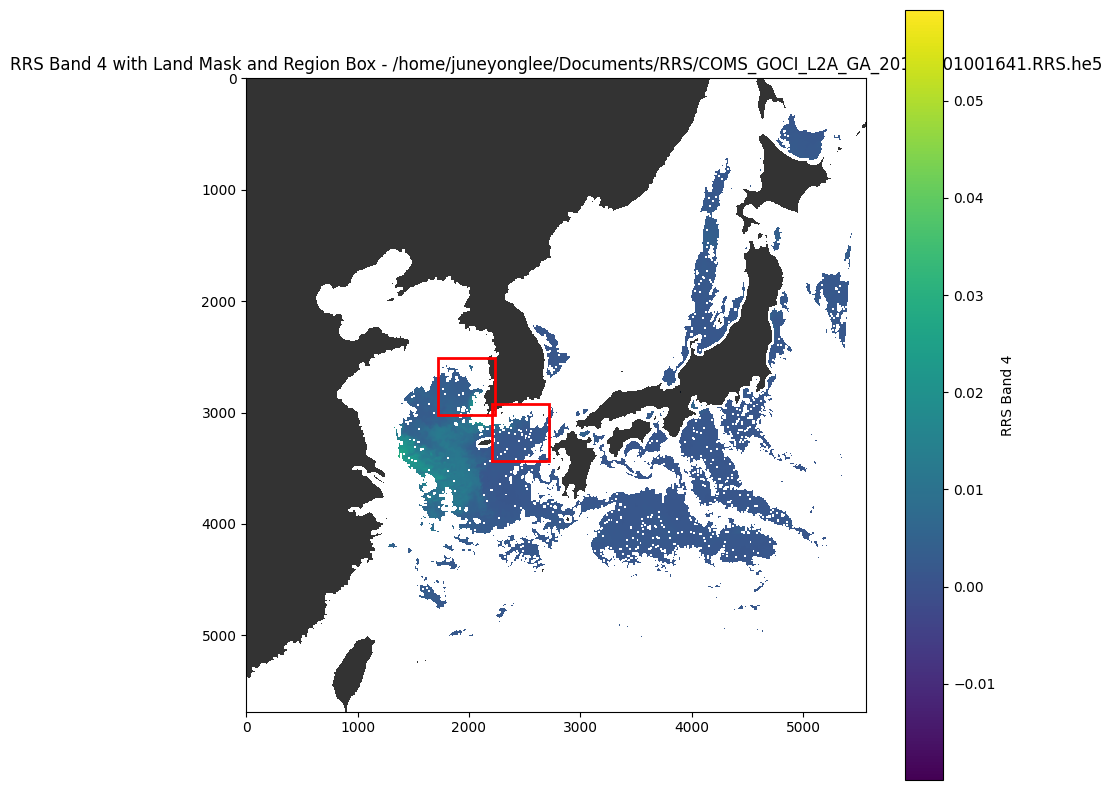

In [ ]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap

# RRS 파일 경로 및 육지/바다 npy 파일 경로
file_path = '/home/juneyonglee/Documents/RRS/COMS_GOCI_L2A_GA_20110401001641.RRS.he5'

land_mask_path = '/home/juneyonglee/Desktop/AY_ust/preprocessing/is_land_on_GOCI.npy'

# 사용할 밴드 리스트 (2, 3, 4번 밴드 예시)
band_lst = [2, 3, 4]

# Define the patch size and region coordinates
patch_size = 512

# # 낙동강 좌표 설정 (픽셀 좌표, 중간좌표 기준)
# region1_x_min, region1_x_max = 2336, 2592
# region1_y_min, region1_y_max = 3053, 3309
# # 새만금 좌표 설정 (픽셀 좌표, 중간좌표 기준)
# region2_x_min, region2_x_max = 1851, 2107
# region2_y_min, region2_y_max = 2639, 2895

# Nakdong coordinates  (2464,3181)
region1_center_x, region1_center_y = (2336 + 2592) // 2, (3053 + 3309) // 2
# Saemangeum coordinates (1979, 2767)
region2_center_x, region2_center_y = (1851 + 2107) // 2, (2639 + 2895) // 2

# Calculate the top-left coordinates for the 512x512 patches (2208,2925) (2720,3437)
region1_x_min, region1_y_min = region1_center_x - patch_size // 2, region1_center_y - patch_size // 2
region1_x_max, region1_y_max = region1_center_x + patch_size // 2, region1_center_y + patch_size // 2
#                                                            (1979,2511)  (2235,3023)
region2_x_min, region2_y_min = region2_center_x - patch_size // 2, region2_center_y - patch_size // 2
region2_x_max, region2_y_max = region2_center_x + patch_size // 2, region2_center_y + patch_size // 2

def display_rrs_with_land_mask_and_box(file_path, land_mask_path, band_lst, region1_x_min, region1_x_max, region1_y_min, region1_y_max, region2_x_min, region2_x_max, region2_y_min, region2_y_max):
    # 육지/바다 마스크 불러오기
    land_mask = np.load(land_mask_path)

    # netCDF 파일 열기
    try:
        f = nc.Dataset(file_path, 'r')
    except:
        print(f"Failed to open file: {file_path}")
        return

    # 각 밴드에 대해 데이터 읽고 시각화
    for band in band_lst:
        try:
            # netCDF 형식으로 데이터를 읽음
            rrs_data = f['HDFEOS']['GRIDS']['Image Data']['Data Fields']['Band ' + str(band) + ' RRS Image Pixel Values']
        except KeyError:
            print(f"Band {band} not found in file {file_path}")
            continue

        # numpy 배열로 변환
        np_rrs = np.array(rrs_data)

        # 고유값 출력
        unique_values = np.unique(np_rrs)
        print(f"Band {band} unique values: {unique_values}")

        # 데이터 유형 확인 (8비트 또는 16비트)
        data_type = np_rrs.dtype
        print(f"Band {band} data type: {data_type}")
        
        # 데이터가 8비트인지 16비트인지 확인
        if data_type == np.uint8:
            print(f"Band {band} is 8-bit data.")
        elif data_type == np.uint16:
            print(f"Band {band} is 16-bit data.")
        else:
            print(f"Band {band} has data type: {data_type}")

        # 육지 마스크 크기 맞추기 (전체 범위로)
        land_mask_cropped = land_mask[:np_rrs.shape[0], :np_rrs.shape[1]]

        # 결측치를 처리 (보통 -999.0 값을 결측치로 가정)
        np_rrs = np.where(np_rrs == -999.0, np.nan, np_rrs)

        # 이미지 출력
        plt.figure(figsize=(10, 10))
        
        # RRS 데이터 이미지
        plt.imshow(np_rrs, cmap='viridis', alpha=1)
        plt.colorbar(label=f'RRS Band {band}')
        
        # 육지 마스크를 빨간색으로 강조 (land_mask가 1이면 육지, 0이면 바다라고 가정)
        plt.imshow(np.ma.masked_where(land_mask_cropped == 0, land_mask_cropped), cmap=ListedColormap(['black', 'white']), alpha=0.8)

        # 낙동강 좌표 범위에 빨간색 사각형 추가
        rect1 = Rectangle((region1_x_min, region1_y_min), region1_x_max - region1_x_min, region1_y_max - region1_y_min,
                         linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect1)

        # 새만금 좌표 범위에 빨간색 사각형 추가
        rect2 = Rectangle((region2_x_min, region2_y_min), region2_x_max - region2_x_min, region2_y_max - region2_y_min,
                         linewidth=2, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect2)

        plt.title(f'RRS Band {band} with Land Mask and Region Box - {file_path}')
        plt.show()

    # 파일 닫기
    f.close()

# 밴드별로 RRS 데이터와 육지 마스크, 새만금 및 낙동강 좌표 범위에 네모 박스 표시
display_rrs_with_land_mask_and_box(file_path, land_mask_path, band_lst, region1_x_min, region1_x_max, region1_y_min, region1_y_max, region2_x_min, region2_x_max, region2_y_min, region2_y_max)


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff  # For reading TIFF files

# 최상위 디렉토리 경로 설정
root_directory = "/home/juneyonglee/Documents/RRS_preprocessed"

# 사용자 정의 컬러맵 생성 (해양 데이터용)
def create_custom_cmap():
    viridis = plt.cm.get_cmap('viridis', 256)  # 256개 색상 사용
    return viridis

# 사용자 정의 컬러맵 설정
custom_cmap = create_custom_cmap()

# 디렉토리 내의 모든 하위 폴더와 파일을 순차적으로 처리
for dirpath, dirnames, filenames in os.walk(root_directory):
    # 해당 폴더 내의 모든 tiff 파일을 처리
    for filename in filenames:
        if filename.endswith(".tiff"):  # TIFF 파일만 선택
            file_path = os.path.join(dirpath, filename)
            
            # tifffile을 사용하여 이미지 불러오기 (16비트 이미지로 읽기)
            img = tiff.imread(file_path)

            if img is None:
                print(f"{filename} could not be loaded.")
                continue
            
            print(f"Loaded {filename} with shape {img.shape} and dtype {img.dtype}")

            # NaN 값 비율 계산
            total_pixels = img.size
            nan_count = np.count_nonzero(np.isnan(img))
            nan_ratio = (nan_count / total_pixels) * 100

            # 0 값 비율 계산
            zero_count = np.count_nonzero(img == 0)
            zero_ratio = (zero_count / total_pixels) * 100

            # Unique 값 계산
            unique_values = np.unique(img[~np.isnan(img)])  # NaN은 제외하고 유니크 값 계산

            # 결과 출력
            print(f"{filename} 전체 NaN 값 비율: {nan_ratio:.2f}%")
            print(f"{filename} 0 값 비율: {zero_ratio:.2f}%")
            print(f"{filename} 유니크 값: {unique_values}")

            # 이미지 표시
            plt.imshow(img, cmap=custom_cmap, interpolation='none')
            plt.axis('off')  # 축 제거
            plt.colorbar(label='Pixel Value')  # 컬러맵 바 추가
            plt.title(f"{filename}")  # 파일명 출력

            plt.show()  # 각 이미지별로 별도 창으로 보여줌


/tmp/ipykernel_12064/3193535602.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis', 256)  # 256개 색상 사용


Loaded 20240101_nak.png with shape (1108, 1108) and dtype uint8
20240101_nak.png Unique Values: [14. 16. 17. 18. 19. 20.]
20240101_nak.png NaN Ratio: 5.63%
20240101_nak.png Zero Value Ratio: 0.00%


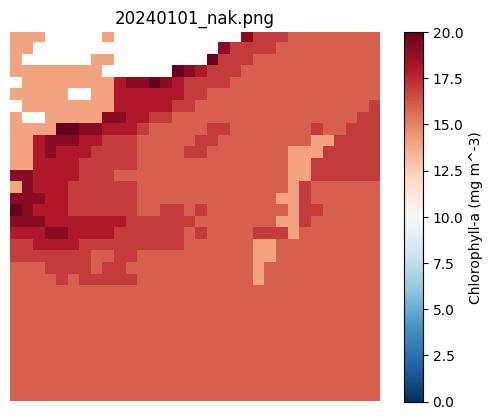

Loaded 20240101_sae.png with shape (1108, 1108) and dtype uint8
20240101_sae.png Unique Values: [14.]
20240101_sae.png NaN Ratio: 65.53%
20240101_sae.png Zero Value Ratio: 0.00%


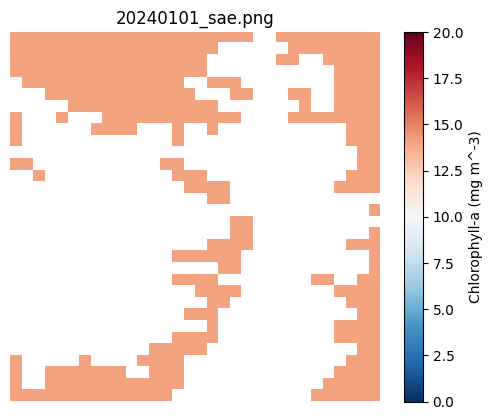

Loaded 20240117_nak.png with shape (1108, 1108) and dtype uint8
20240117_nak.png Unique Values: [14. 15. 16. 17. 18. 19. 20.]
20240117_nak.png NaN Ratio: 1.72%
20240117_nak.png Zero Value Ratio: 0.00%


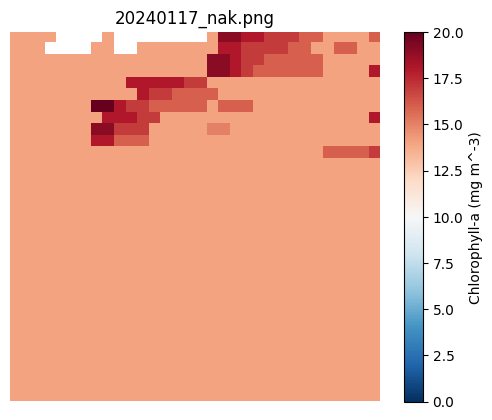

Loaded 20240117_sae.png with shape (1108, 1108) and dtype uint8
20240117_sae.png Unique Values: [14.]
20240117_sae.png NaN Ratio: 8.48%
20240117_sae.png Zero Value Ratio: 0.00%


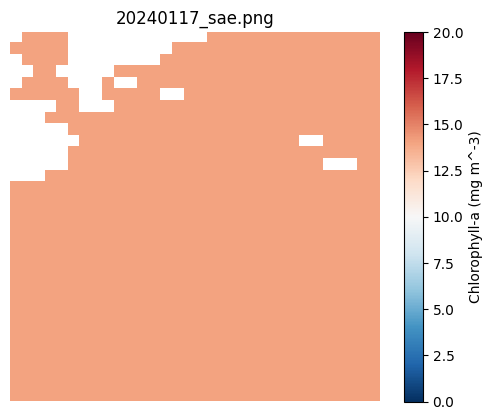

Loaded 20240109_nak.png with shape (1108, 1108) and dtype uint8
20240109_nak.png Unique Values: [14. 16. 17. 18. 19. 20.]
20240109_nak.png NaN Ratio: 6.79%
20240109_nak.png Zero Value Ratio: 0.00%


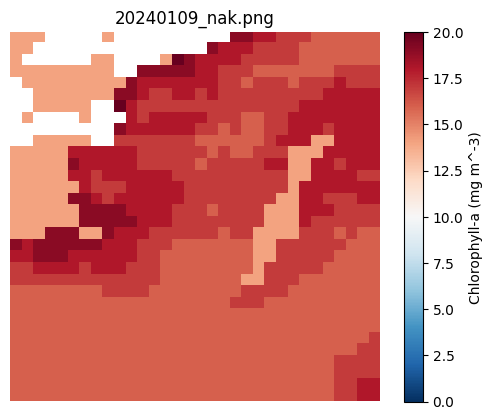

Loaded 20240109_sae.png with shape (1108, 1108) and dtype uint8
20240109_sae.png Unique Values: [14.]
20240109_sae.png NaN Ratio: 84.58%
20240109_sae.png Zero Value Ratio: 0.00%


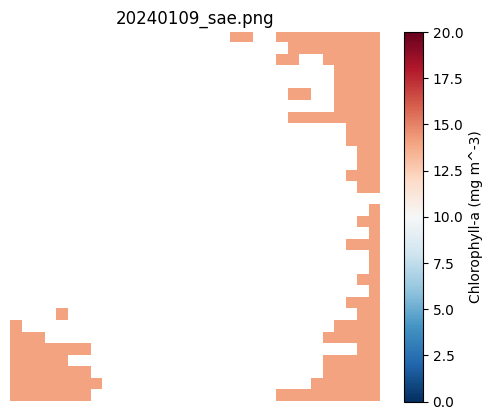

Loaded 20240125_nak.png with shape (1108, 1108) and dtype uint8
20240125_nak.png Unique Values: [14. 16. 17. 18. 19. 20.]
20240125_nak.png NaN Ratio: 5.74%
20240125_nak.png Zero Value Ratio: 0.00%


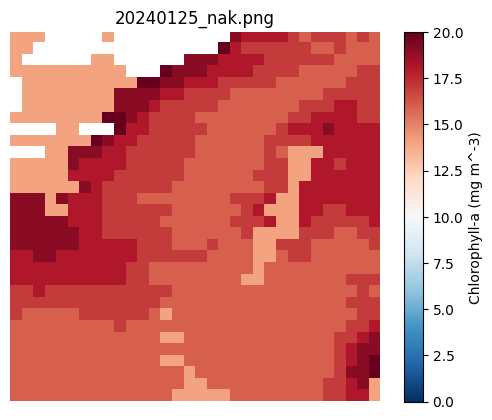

Loaded 20240125_sae.png with shape (1108, 1108) and dtype uint8
20240125_sae.png Unique Values: [14.]
20240125_sae.png NaN Ratio: 75.78%
20240125_sae.png Zero Value Ratio: 0.00%


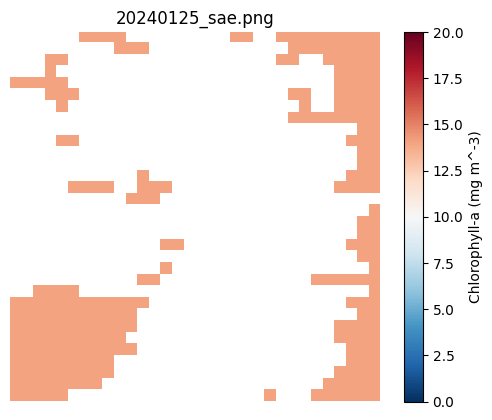

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image  # For reading PNG files

# Set the root directory where preprocessed images are stored
root_directory = "/media/juneyonglee/My Book/Preprocessed/MODIS_32patch_noresize/2024/01/"

# Custom colormap for ocean data
def create_custom_cmap():
    viridis = plt.colormaps['viridis']
    return viridis

# Set custom colormap
custom_cmap = create_custom_cmap()

# Process all PNG files in the directory
for dirpath, dirnames, filenames in os.walk(root_directory):
    for filename in filenames:
        # Skip files containing '_bar' in their name
        if filename.endswith(".png") and '_bar' not in filename:
            file_path = os.path.join(dirpath, filename)
            
            # Load image using PIL (for .png files)
            img = np.array(Image.open(file_path).convert('L'))  # Convert to grayscale

            if img is None:
                print(f"{filename} could not be loaded.")
                continue
            
            print(f"Loaded {filename} with shape {img.shape} and dtype {img.dtype}")

            # Convert MODIS fill values (-999 or similar) and values above 20 to NaN
            img = np.where((img == -999) | (img > 20), np.nan, img)

            # Calculate NaN ratio
            total_pixels = img.size
            nan_count = np.count_nonzero(np.isnan(img))
            nan_ratio = (nan_count / total_pixels) * 100

            # Calculate zero ratio
            zero_count = np.count_nonzero(img == 0)
            zero_ratio = (zero_count / total_pixels) * 100

            # Calculate unique values (excluding NaNs)
            unique_values = np.unique(img[~np.isnan(img)])

            # Display only a sample of unique values if there are too many
            if len(unique_values) > 10:
                unique_values_sample = unique_values[:10]
                print(f"{filename} Unique Values (Sample): {unique_values_sample} ... [{len(unique_values)} total unique values]")
            else:
                print(f"{filename} Unique Values: {unique_values}")

            # Print statistics
            print(f"{filename} NaN Ratio: {nan_ratio:.2f}%")
            print(f"{filename} Zero Value Ratio: {zero_ratio:.2f}%")

            # Display the image
            plt.imshow(img,cmap='RdBu_r', interpolation='none', vmin=0, vmax=20)
            plt.axis('off')
            plt.colorbar(label='Chlorophyll-a (mg m^-3)')
            plt.title(f"{filename}")
            plt.show()


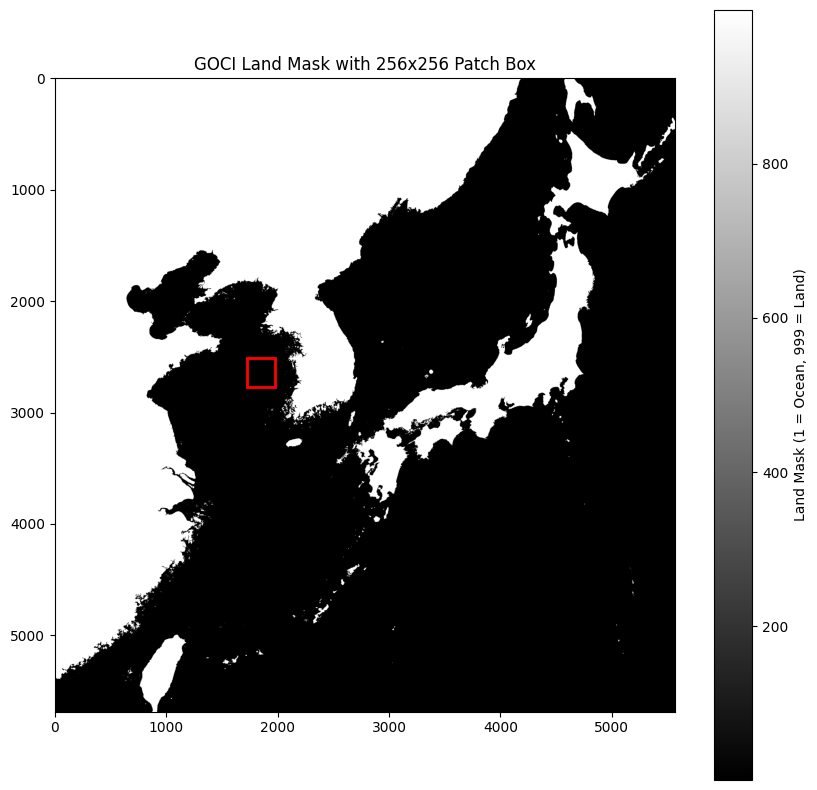

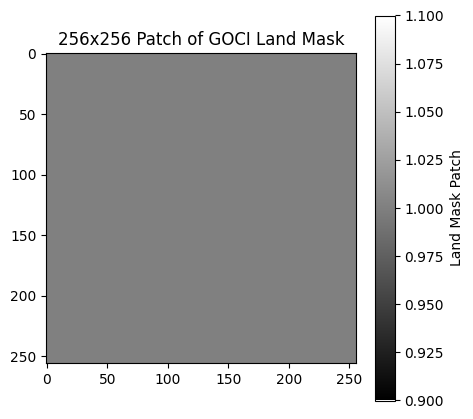

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import re

# 육지/바다 npy 파일 경로
land_mask_path = '/home/juneyonglee/Desktop/AY_ust/preprocessing/is_land_on_GOCI_modified_1_999.npy'
goci_land_sea_mask = np.load(land_mask_path)  # GOCI 마스크 로드

# 파일명에서 row, col 좌표 추출
filename = '/home/juneyonglee/MyData/backup_20240914/AY_UST/ust21_GOCI_differencemap/difference_map_saemangeum_20200904_r1724_c2511.png'
coordinates = re.search(r'r(\d+)_c(\d+)', filename)
if coordinates:
    row, col = int(coordinates.group(1)), int(coordinates.group(2))
else:
    print("Filename does not contain row and col information in expected format.")
    row, col = None, None

# Define the patch size
patch_size = 256

# Calculate patch boundaries
patch_x_min, patch_x_max = row, row + patch_size
patch_y_min, patch_y_max = col, col + patch_size

def display_land_mask_with_box(goci_land_sea_mask, patch_x_min, patch_x_max, patch_y_min, patch_y_max):
    # 전체 육지 마스크 이미지에 패치 표시
    plt.figure(figsize=(10, 10))
    plt.imshow(goci_land_sea_mask, cmap='gray', alpha=1)
    plt.colorbar(label='Land Mask (1 = Ocean, 999 = Land)')

    # 256x256 패치에 빨간색 사각형 추가
    rect = Rectangle((patch_x_min, patch_y_min), patch_x_max - patch_x_min, patch_y_max - patch_y_min,
                     linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

    plt.title('GOCI Land Mask with 256x256 Patch Box')
    plt.show()

    # 256x256 패치 추출 및 표시
    patch = goci_land_sea_mask[patch_y_min:patch_y_max, patch_x_min:patch_x_max]
    plt.figure(figsize=(5, 5))
    plt.imshow(patch, cmap='gray')
    plt.colorbar(label='Land Mask Patch')
    plt.title('256x256 Patch of GOCI Land Mask')
    plt.show()

# GOCI 마스크에 패치 범위에 네모 박스 표시 및 패치 추출
display_land_mask_with_box(goci_land_sea_mask, patch_x_min, patch_x_max, patch_y_min, patch_y_max)


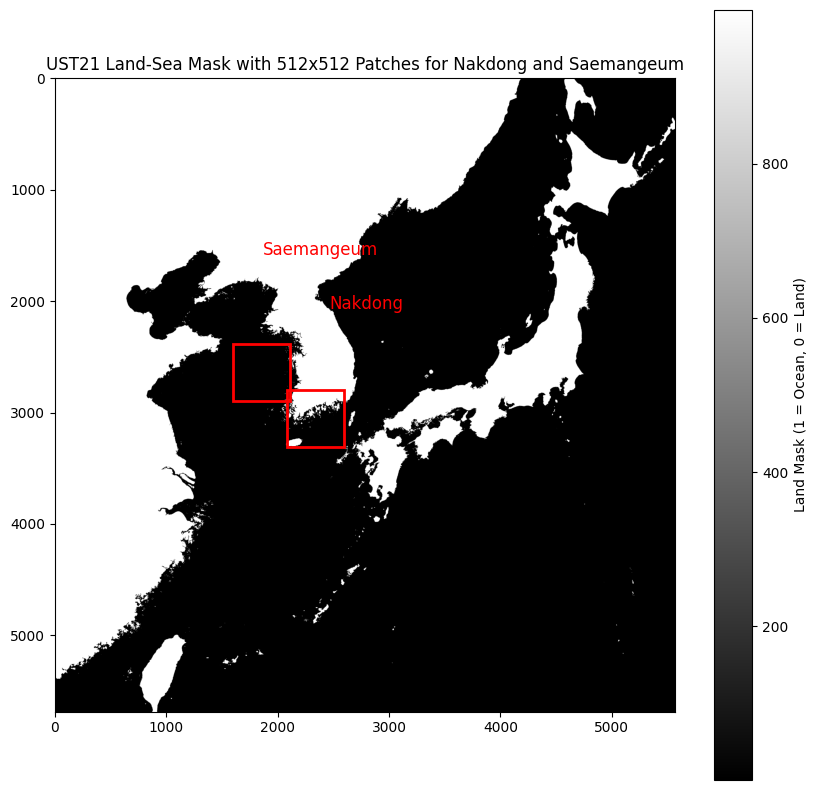

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Paths to UST21 land-sea mask
land_mask_path = '/home/juneyonglee/Desktop/AY_ust/preprocessing/is_land_on_GOCI_modified_1_999.npy'
ust21_land_sea_mask = np.load(land_mask_path)  # Load UST21 land-sea mask

# Coordinates for the centers of the Nakdong and Saemangeum regions
nakdong_center = (2336, 3053)  # (row, col)
saemangeum_center = (1851, 2639)  # (row, col)

# Patch size
patch_size = 512

def display_ust21_land_mask_with_patches(land_sea_mask, nakdong_center, saemangeum_center, patch_size=512):
    # Calculate the top-left corner of the patches based on the center coordinates
    nakdong_top_left = (nakdong_center[0] - patch_size // 2, nakdong_center[1] - patch_size // 2)
    saemangeum_top_left = (saemangeum_center[0] - patch_size // 2, saemangeum_center[1] - patch_size // 2)

    # Display the UST21 land-sea mask
    plt.figure(figsize=(10, 10))
    plt.imshow(land_sea_mask, cmap='gray', alpha=1)
    plt.colorbar(label='Land Mask (1 = Ocean, 0 = Land)')
    
    # Draw red rectangle for Nakdong
    nakdong_rect = Rectangle(nakdong_top_left, patch_size, patch_size, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(nakdong_rect)
    plt.text(nakdong_top_left[1], nakdong_top_left[0] - 10, 'Nakdong', color='red', fontsize=12, ha='center')

    # Draw red rectangle for Saemangeum
    saemangeum_rect = Rectangle(saemangeum_top_left, patch_size, patch_size, linewidth=2, edgecolor='red', facecolor='none')
    plt.gca().add_patch(saemangeum_rect)
    plt.text(saemangeum_top_left[1], saemangeum_top_left[0] - 10, 'Saemangeum', color='red', fontsize=12, ha='center')

    # Set title and show the plot
    plt.title('UST21 Land-Sea Mask with 512x512 Patches for Nakdong and Saemangeum')
    plt.show()

# Display the land-sea mask with Nakdong and Saemangeum patches
display_ust21_land_mask_with_patches(ust21_land_sea_mask, nakdong_center, saemangeum_center, patch_size)
